# Match filter experiments

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import scipy.signal as signal
import scipy
import xrsignal
import os
from scipy import io
from matplotlib import pyplot as plt
from numpy import matlib
import hvplot.xarray
from dask.distributed import Client
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

%load_ext autoreload
%autoreload 2

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 62.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39343,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 62.79 GiB
Comm: tcp://127.0.0.1:41005,Total threads: 4
Dashboard: http://127.0.0.1:36519/status,Memory: 7.85 GiB
Nanny: tcp://127.0.0.1:37531,


## Just try it for one first

In [3]:
import ooipy
from datetime import datetime
import numpy as np
from scipy import signal, io
import matplotlib.pyplot as plt
import scipy

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

%load_ext autoreload
%autoreload 2
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### construct replica from wav file

In [176]:
fs, Tx = io.wavfile.read('tx_signal.wav')
t = np.arange(0, len(Tx)/fs, 1/fs)

Tx200 = Tx[::12]
t200 = np.arange(0, 27.28, 0.005)

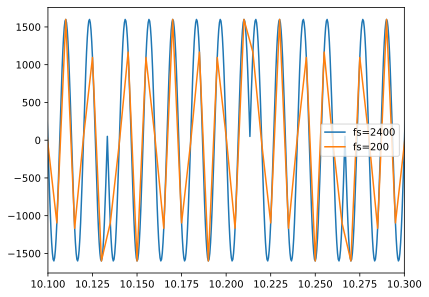

In [179]:
plt.plot(t, Tx, label='fs=2400')
#plt.plot(t, Tx_filt, label='fs=2400, fc=90')
plt.plot(t200, Tx200, label='fs=200')
plt.xlim([10.1,10.3])
plt.legend()

- this seems like the errors associated with the anti-aliasing filter are not big enough to prevent a signal detection
- but I still don't see a reception
- and I still need to be able to construct the sequency anyways...

#### looking at some psd plots

In [180]:
f, psd = signal.welch(Tx, nperseg=2048)
f, psd2 = signal.welch(Tx_filt, nperseg=2048)

In [181]:
w,h = signal.freqz(b,a)

/tmp/ipykernel_8633/2126797091.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w/(np.pi),20*np.log10(np.abs(h**2)))


(0.0, 0.5)

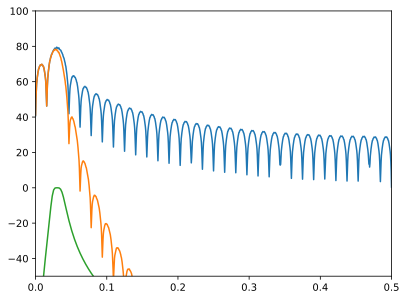

In [182]:
plt.plot(f, 10*np.log10(psd))
plt.plot(f, 10*np.log10(psd2))
plt.plot(w/(np.pi),20*np.log10(np.abs(h**2)))

plt.ylim([-50,100])
plt.xlim([0,0.5])

In [36]:
sequenc_int = scipy.interpolate.interp1d(t, Tx, kind='cubic')

In [17]:
t200 = np.arange(0,27.28, 0.005)
Tx200 = sequenc_int(t200)

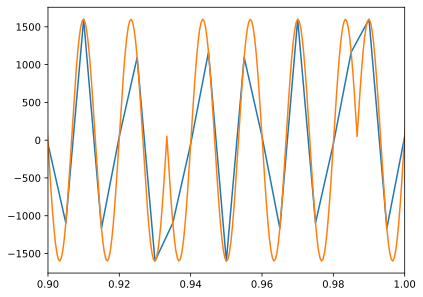

In [20]:
plt.plot(t200, Tx200)
plt.xlim([0.9,1])

plt.plot(t, Tx)

### do SP (in exact order as david)

In [185]:
start_time = datetime(2023,8,11)
end_time = datetime(2023,8,11, 2)

hdata = ooipy.get_acoustic_data_LF(start_time, end_time, node='HYS14')
hdata_np = hdata.data

In [199]:
io.savemat('singleTx.mat', {'hdata':hdata_np})

In [186]:
hdata_nm = hdata_np - np.mean(hdata_np)

In [187]:
b,a = signal.butter(2, np.array([55, 95])/2400, btype='bandpass')
data_filt = signal.filtfilt(b,a,hdata_np)

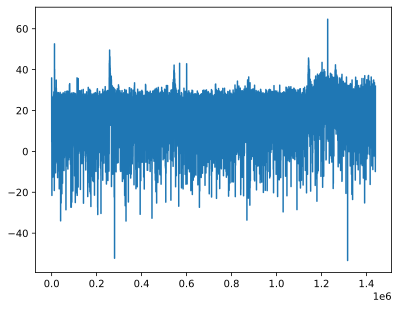

In [190]:
data_c = signal.hilbert(data_filt)
plt.plot(20*np.log10(np.abs(data_c)))

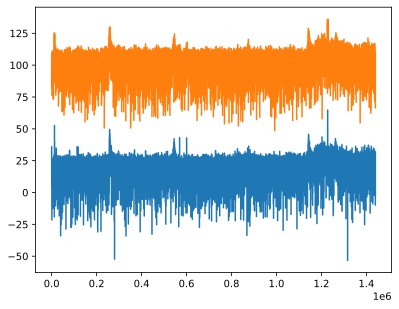

In [191]:
data_match = signal.correlate(data_c, Tx200, mode='same')
plt.plot(20*np.log10(np.abs(data_c)))
plt.plot(20*np.log10(np.abs(data_match)))

In [192]:
# reshape data
data_rs = data_c[:int(np.floor(len(data_match)/len(Tx200))*len(Tx200))].reshape((len(Tx200), int(np.floor(len(data_match)/len(Tx200)))))

In [193]:
data_rs.shape

(5456, 263)

In [196]:
def moving_average(arr, window_size, axis):
    if window_size <= 0:
        raise ValueError("Window size must be positive")
    if axis >= arr.ndim:
        raise ValueError("Invalid axis")

    kernel = np.ones(window_size) / window_size
    smoothed = np.apply_along_axis(lambda x: np.convolve(x, kernel, mode='same'), axis, arr)
    return smoothed
    
data_avg = moving_average(data_rs, window_size=20, axis=1)

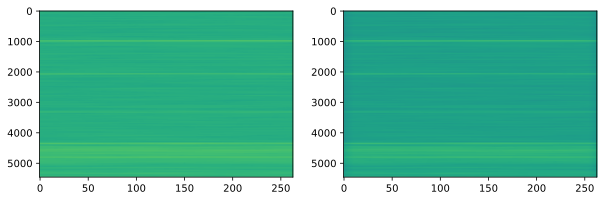

In [197]:
fig = plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.imshow(20*np.log10(np.abs(data_rs)), rasterized=True, aspect='auto')

plt.subplot(1,2,2)
plt.imshow(20*np.log10(np.abs(data_avg)), rasterized=True, aspect='auto')

- this is just not working
- no idea if this is the problem, but **either way**, I'm going to need to generate the sequence, so let's do that

In [131]:
data_rs.shape

(65472, 3167)

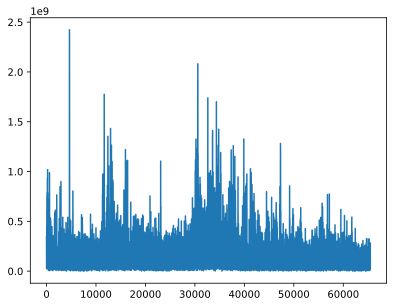

In [128]:
plt.plot(np.abs(data_rs[:,:500].sum(axis=1)))

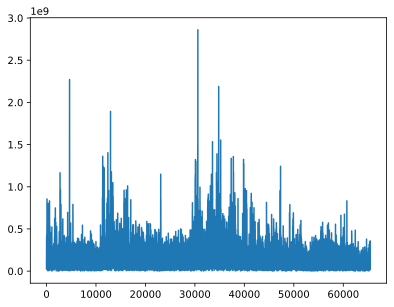

In [129]:
plt.plot(np.abs(np.sum(data_rs, axis=1)))

## Build distributed version

### open dataset

In [3]:
fns = '/datadrive/kauai/transmissions/*.nc'
ds = xr.open_mfdataset(fns)

ds = ds.assign_coords({'time':np.arange(0,3600*2 + 1/1000, 1/1000)})

### create 20 min transmitted signal

In [4]:
fs, Tx = io.wavfile.read('tx_signal.wav')
t = np.arange(0, 65472/fs, 1/fs)

Tx1000 = signal.resample(Tx, int(len(Tx)/2.4))
t1000 = np.arange(0, len(Tx1000)/1000, 1/1000)

t_20min = np.arange(0,20*60, 1/1000)
Tx_20min = matlib.repmat(Tx1000, 1, 44).flatten()[:20*60*1000]

In [5]:
tx_coord = np.arange(0,60*20, 1/1000)
Tx_20min_x = xr.DataArray(Tx_20min, dims=['time'], coords={'time':tx_coord})

Tx1000_x = xr.DataArray(Tx1000, dims=['time'], coords={'time':t1000})

In [21]:
t1000

array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 2.7277e+01, 2.7278e+01,
       2.7279e+01])

## build sequence

In [17]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy import signal, io

In [135]:
m,_ = signal.max_len_seq(10, state=[0,0,0,0,0,0,0,0,0,1])

In [14]:
nbits = 10  # Number of shift register stages
start_state = np.array([0,0,0,0,0,0,0,0,0,1])  # Start state for the shift registers

# Octal representation of the polynomial 3471 is [0, 1, 1, 1, 0, 0, 0, 1]
polynomial = [1,8,4,9]

# Generate the maximum length sequence using the provided parameters
m,_ = signal.max_len_seq(nbits, state=start_state, taps=polynomial)


In [60]:
(m - m_wav)[:30]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0., -1.,  0.,  0.,  0.,  0., -1.,  1., -1.,  0.,  0., -1.,  1.,
        0.,  0., -1.,  0.])

In [18]:
fs, Tx = io.wavfile.read('tx_signal.wav')
t = np.arange(0, len(Tx)/fs, 1/fs)

# sort of hack out the sequency from the wave file
m_wav = (-1*np.reshape(Tx[:int(np.floor(len(Tx)/64)*64)], (int(np.floor(len(Tx)/64)), 64))[:,10] + 1458)/2954

In [58]:
m_wav[:30]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1.,
       1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1.])